In [1]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)
from vertical_spacing_main import main, draw_bbox_coord
from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)
from left_right_on_block import left_right_margin
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy
import numpy as np

from dhiraj_break_block_condition import process_page_blocks as dd_process_page_blocks
from dhiraj_break_block_condition import draw_sub_blocks
import matplotlib.pyplot as plt

## Draw the boxes on document pages

In [2]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color ,width =3)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [71]:
#base_dir   = '/home/naresh/Tesseract/document-structure/data'
base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'

input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
#filename   = 'v241.pdf'
#filename   = 'downloaded.pdf'
#filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'
filename   = '20.03.2020.pdf'
#filename    = '4603_2017_11_1503_19663_Judgement_15-Jan-2020.pdf'

In [72]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: 20.03.2020.pdf


# vertical spacings

In [73]:
block_configs = {
    "right_margin_threshold": 0.10,  "left_margin_threshold": 0.10,
    "right_break_threshold": 0.05,   "left_break_threshold": 0.05,
    "header_left_threshold": 0.70,  "header_right_threshold": 0.85,
    "space_multiply_factor": 2.0
}
def process_page_blocks(page_df, configs,block_configs, debug=False):
    cols      = page_df.columns.values.tolist()
    
    df        = pd.DataFrame(columns=cols)
    
    block_index = 0
    for index, row in page_df.iterrows():
        if row['children'] == None:
            df = df.append(page_df.iloc[index])
        else:
            dfs = process_block(page_df.iloc[index], block_configs)
            df = df.append(dfs)
    return df

def process_block(children, block_configs):
    
    dfs = left_right_margin(children, block_configs)
    return dfs


In [74]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (13) in file (20.03.2020.xml)


In [75]:
document_configs = {
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}


break_config = {'margin_support' :2 , 'width_threshold':0.65}

In [76]:
file_index=2
img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]


In [77]:
in_df   = df.loc[:]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)



p_df = process_page_blocks(v_df, document_configs,block_configs)
p_df = p_df.reset_index()
p_df = p_df.drop(columns=['level_0','index'])


image = draw_box(img_filepath, page_width, page_height, v_df, color='red')
# show_df(h_df)
#image

/home/dhiraj/Documents/Anuwad/document-structure/notebooks/left_right_on_block.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  children_df.sort_values('text_top', axis = 0, ascending = True, inplace=True)


In [78]:
list_of_blocks =  dd_process_page_blocks(v_df,image,page_num=file_index +1 ,configs=break_config)


dd_image       = draw_sub_blocks( list_of_blocks, image , margin = 2, color = 'green')
ns_image       = draw_box(img_filepath, page_width, page_height, p_df, color='red')

stich_image    = np.hstack([np.array(dd_image),np.array(ns_image)])


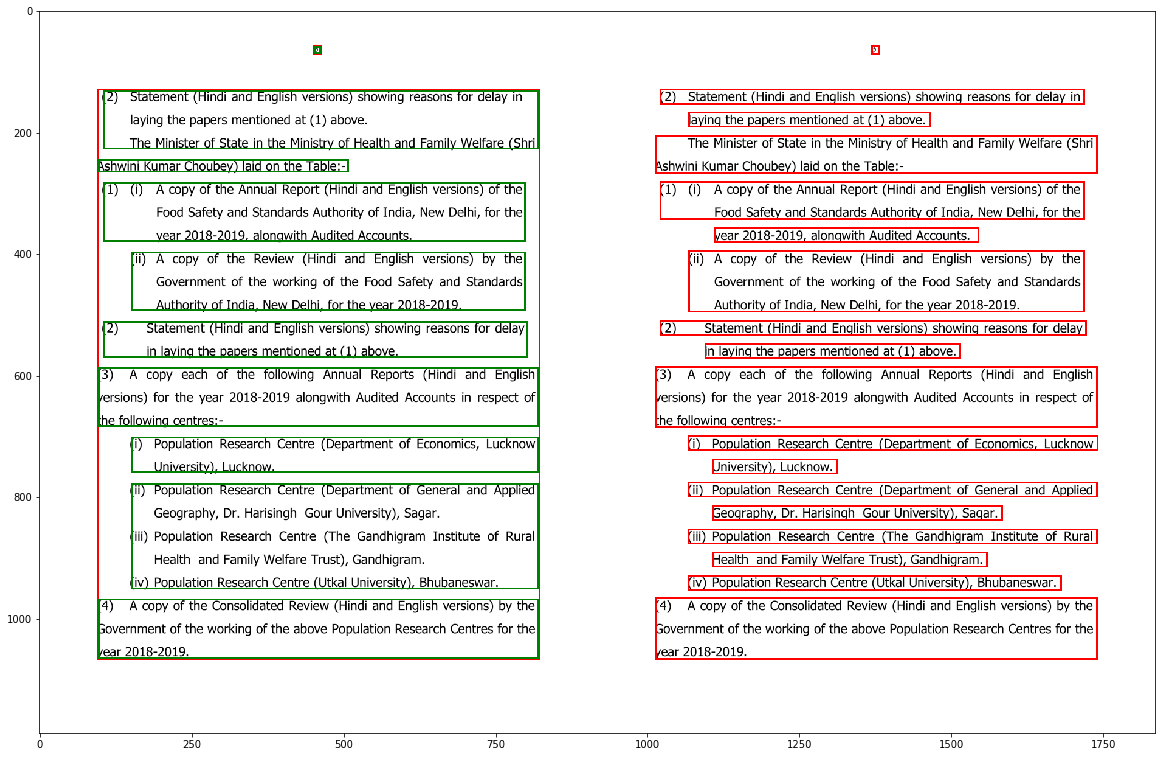

In [79]:
#%matplotlib
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(stich_image)
